# **UC2. Is there something wrong with my network subscribers? ML Approach**


In our network, the Provider Edge devices also function as Broadband Network Gateways (BNGs), providing Internet access to subscribers based on their region

The challenge is to determine whether the number of subscribers in a BNG is normal or not. Since this metric changes over time due to seasonality, setting a fixed threshold is not feasible. Instead, a mechanism is needed to learn the normal values and detect deviations as anomalies.

The goal is not to optimize these algorithms but to demonstrate how they can be programmed, trained, and how they perform in this use case. The same methodology can be applied to other metrics of interest.

# Extra libraries to install

# Connection to drive and path definition (Just for Google Colab Lab)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
path_files =('/content/drive/MyDrive/Colab Notebooks/Files')


# ***OR***

# Connection path definition (Just for AWS Jupiter Notebook)

In [ ]:
import sys
path_files ='./Files'

# Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from os import listdir
from os.path import isfile, join

# Data Collection, normalization & visualization

 We will load a data set that contains number of subscribers for PE-4 for a period of 30 days, with **5 minute frequency**

In [4]:
metric_df=pd.read_csv(join(path_files,'bng_subscribers_metric.csv'),index_col=0)

In [5]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1747246843,158950.811983,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
1,1747247143,155336.043010,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
2,1747247443,149299.637403,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
3,1747247743,152540.393954,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
4,1747248043,158639.886226,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
...,...,...,...,...,...,...,...,...,...,...
8636,1749837643,126668.597260,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8637,1749837943,134693.037815,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8638,1749838243,129634.681373,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8639,1749838543,135459.696090,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4


In [6]:
ds_column = []
for i,obs in metric_df.iterrows():
    #new_timestamp = datetime.fromtimestamp(obs['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    new_timestamp = datetime.fromtimestamp(obs['timestamp'])
    ds_column.append(new_timestamp)
metric_df['ds']=ds_column
metric_df['y']=metric_df['bng_subscribers']



In [7]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y
0,1747246843,158950.811983,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:20:43,158950.811983
1,1747247143,155336.043010,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:25:43,155336.043010
2,1747247443,149299.637403,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:30:43,149299.637403
3,1747247743,152540.393954,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:35:43,152540.393954
4,1747248043,158639.886226,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-05-14 18:40:43,158639.886226
...,...,...,...,...,...,...,...,...,...,...,...,...
8636,1749837643,126668.597260,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:00:43,126668.597260
8637,1749837943,134693.037815,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:05:43,134693.037815
8638,1749838243,129634.681373,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:10:43,129634.681373
8639,1749838543,135459.696090,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2025-06-13 18:15:43,135459.696090


This is how the data looks like for the target metric:

Text(0.5, 1.0, 'BNG Subscribers')

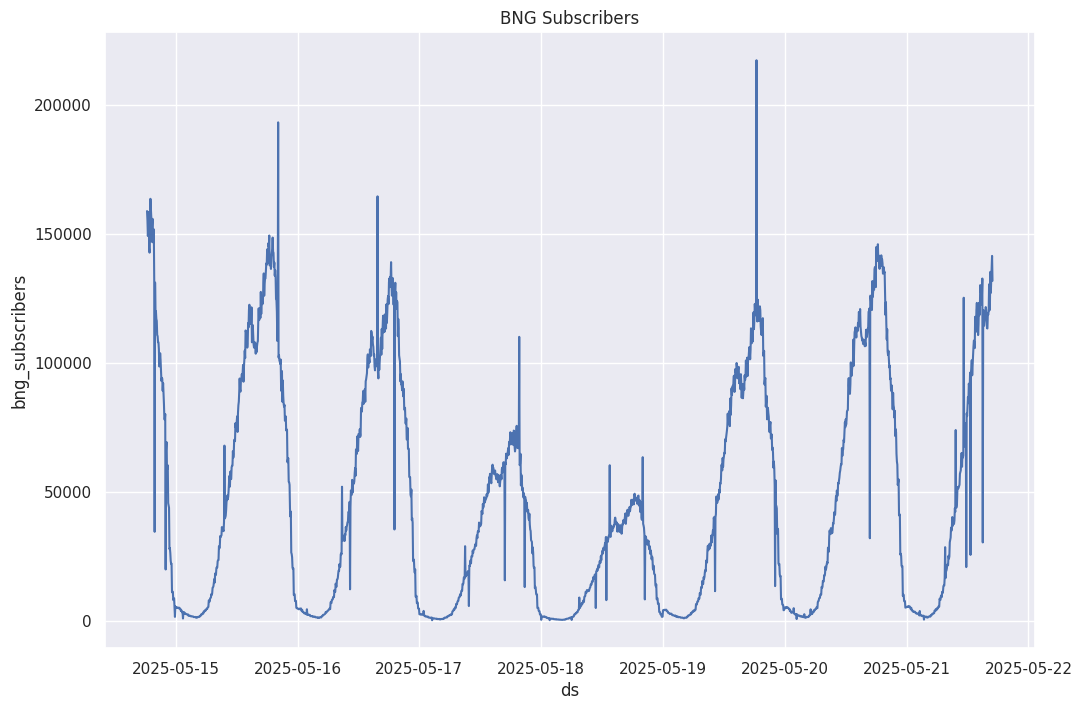

In [8]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:2000], y=metric_df['bng_subscribers'][:2000])
plt.title('BNG Subscribers')

# Rolling window and Z-Score

**Approach 1:** In this first approach, we will use a rolling window in which we will calculate the **median** of the values in such window, and then we will evaluate the **standard deviation**. We will use those to compute what is the "normal" range of values (above and below the median) to determine the acceptable operational range for our metric of interest, and identify the anomalous values.

# Detection Parameters

In [9]:
ROLLING = 12               # Rolling window size
Z_SCORE_THRESHOLD = 3      # Z-score threshold to classify a point as an anomaly
PCTL_MULTIPLIER = 2

# Calculate rolling statistics

In [10]:
metric_df['SMA']=metric_df.loc[:,'y'].rolling(window=ROLLING).median()  # Rolling median
metric_df['std']=metric_df.loc[:,'y'].rolling(window=ROLLING).std()     # Rolling standard deviation

# Compute z-score

In [11]:
metric_df['SMA_diff']=metric_df['y']-metric_df['SMA']        # Difference from the rolling median
metric_df['z_score']=metric_df['SMA_diff']/metric_df['std']  # Z-score normalization

# Detect anomalies

In [12]:
metric_df['z_anomaly']=(abs(metric_df['z_score'])>Z_SCORE_THRESHOLD).astype(int)

# Extract anomaly points

In [13]:
anomaly_df = metric_df[metric_df['z_anomaly']>0]

The Z-score approach is usually the following:  if the deviation is higher than 3 standard deviations, that means it is an anomaly.


#  Visualization

Text(0.5, 1.0, 'BNG Subscribers with anomalies')

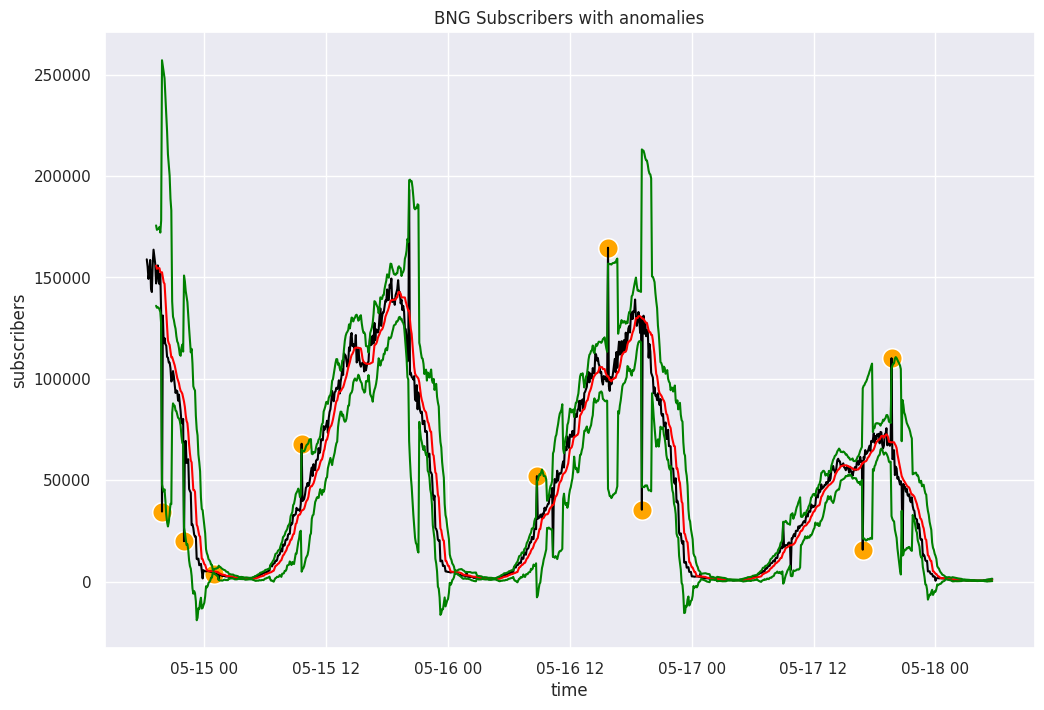

In [14]:

anomaly_mask = anomaly_df.ds < metric_df.loc[1000,'ds']
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['y'][:1000],color='black')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000],color='red')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]+Z_SCORE_THRESHOLD*metric_df['std'][:1000],color='green')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]-Z_SCORE_THRESHOLD*metric_df['std'][:1000],color='green')
sns.scatterplot(x=anomaly_df['ds'][anomaly_mask], y=anomaly_df['y'][anomaly_mask], color='orange',s=200)
plt.xlabel('time')
plt.ylabel('subscribers')
plt.title('BNG Subscribers with anomalies')

Black: Actual BNG subscriber data

Red: Rolling median (trend)

Green: Acceptable range boundaries

Orange: Detected anomalies


Result: Using the standard deviation is problematic because it is highly sensitive to anomalies. As a result, the computed ranges also spike after anomalies occur, which is not ideal.

# Additional plot with prediction interval shading

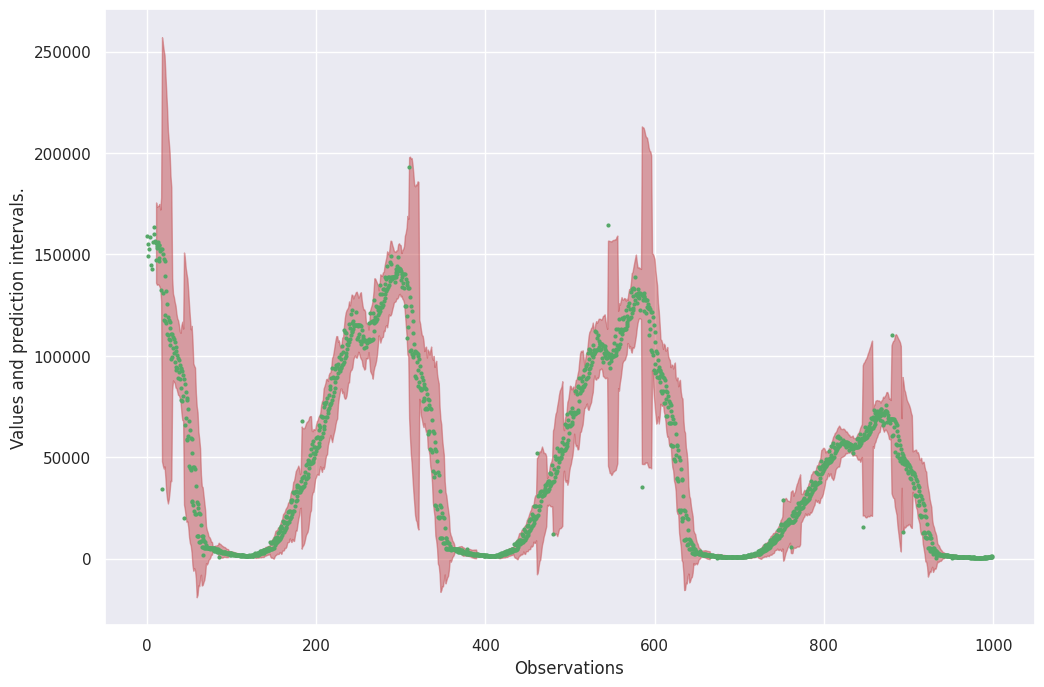

In [15]:
plt.plot(metric_df['y'][:1000],'go',markersize=2,label='Actual')
plt.plot(metric_df['SMA'][:1000],'go',markersize=2,label='Actual')
plt.fill_between(
       np.arange(1000), metric_df['SMA'][:1000]-Z_SCORE_THRESHOLD*metric_df['std'][:1000], metric_df['SMA'][:1000]+Z_SCORE_THRESHOLD*metric_df['std'][:1000], alpha=0.5, color="r",
label="Predicted interval")
plt.xlabel("Observations")
plt.ylabel("Values and prediction intervals.")
plt.show()

**Approach 2:** **Quantiles or percentiles**  can be used to define an acceptable range, typically based on the 95th or 99th percentile. This method helps filter out outliers, as they are likely to be beyond these percentile values.

# Parameters

In [16]:
ROLLING = 12                  # Rolling window size
PCTL_MULTIPLIER = 2           # Multiplier for the 95th percentile threshold

#  Calculate the rolling 95th percentile of the absolute deviation

In [17]:
metric_df['pctl']= np.abs(metric_df['SMA_diff']).rolling(window=ROLLING).quantile(0.95,interpolation='lower')

# Identify anomalies where deviation exceeds threshold

In [18]:
metric_df['z_anomaly_2']=((np.abs(metric_df['SMA_diff'])/metric_df['pctl'])>PCTL_MULTIPLIER).astype(int)


# Extract anomaly points

In [19]:
anomaly_2_df = metric_df[metric_df['z_anomaly_2']>0]

# Visualization of results

Text(0.5, 1.0, 'BNG Subscribers with anomalies')

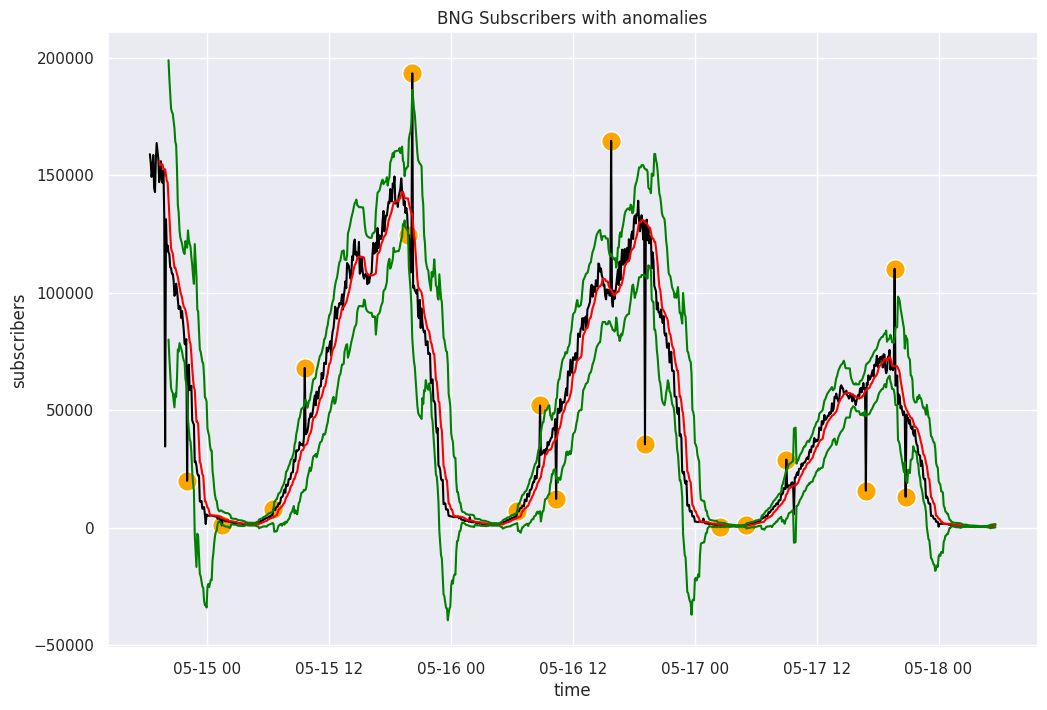

In [20]:
anomaly_mask = anomaly_2_df.ds < metric_df.loc[1000,'ds']
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['y'][:1000],color='black')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000],color='red')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]+PCTL_MULTIPLIER*metric_df['pctl'][:1000],color='green')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]-PCTL_MULTIPLIER*metric_df['pctl'][:1000],color='green')
sns.scatterplot(x=anomaly_2_df['ds'][anomaly_mask], y=anomaly_2_df['y'][anomaly_mask], color='orange',s=200)
plt.xlabel('time')
plt.ylabel('subscribers')
plt.title('BNG Subscribers with anomalies')

Black: Actual BNG subscriber data

Red: Rolling median (trend)

Green: Acceptable range boundaries

Orange: Detected anomalies

More anomalies can now be detected, with ranges influenced by the curve’s slope rather than anomalies. Fine-tuning the rolling window may help optimize detection.

# Show prediction interval as shaded area

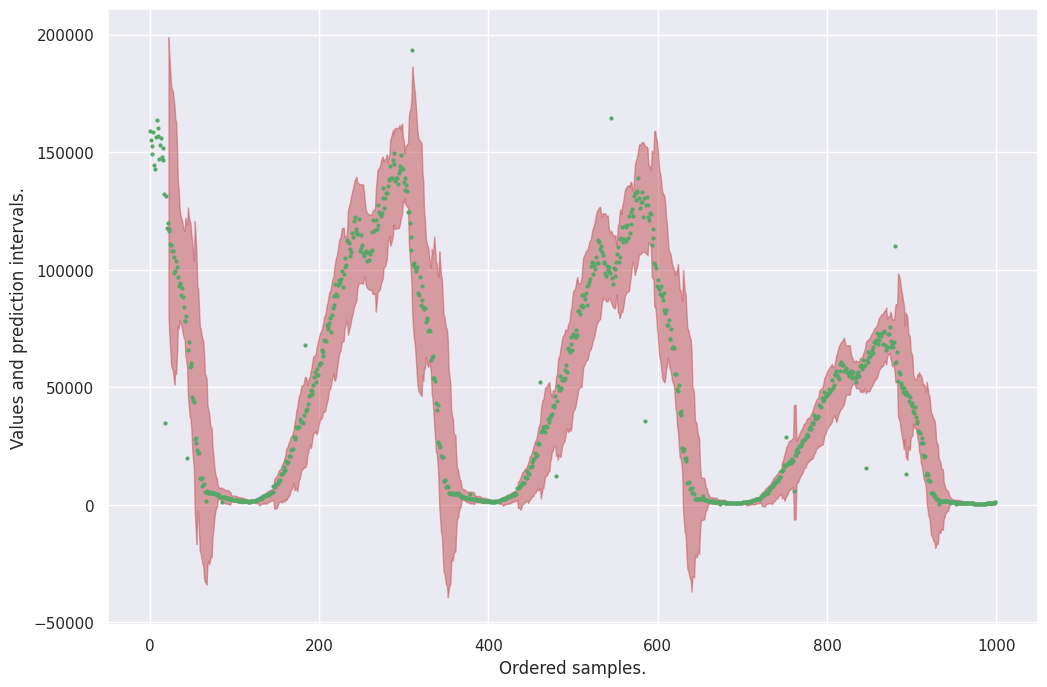

In [21]:
plt.plot(metric_df['y'][:1000],'go',markersize=2,label='Actual')
plt.fill_between(
       np.arange(1000), metric_df['SMA'][:1000]-PCTL_MULTIPLIER*metric_df['pctl'][:1000], metric_df['SMA'][:1000]+PCTL_MULTIPLIER*metric_df['pctl'][:1000], alpha=0.5, color="r",
label="Predicted interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.show()